In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/raid/bling/bram/multilang_timescale


In [4]:
import json

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from src.settings import TrainerSetting

from src.utils.utils import get_surface_dict, get_valid_result
from src.utils.meta import read_result_meta

from src.utils.plot import (
    config_plotting,
    figsize_dict,
    h_cbar_figsize_dict,
    v_cbar_figsize_dict,
    plot_simple_flatmap,
    id_to_label
)


In [5]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

result_meta_dir = ".temp/result_meta/bling"

result_metric = "r2"

alpha = 0.05

plotting_context='paper'

analysis_name = "timescale_score"

figsize_type = 'full'

In [6]:
subject_ids = ["COL", "GFW", "TYE"]

config_plotting(context=plotting_context)

figsize = figsize_dict[figsize_type]
v_cbar_figsize = v_cbar_figsize_dict[figsize_type]
h_cbar_figsize = h_cbar_figsize_dict[figsize_type]

In [7]:
def get_stats(subject_id: str):

    en_feature_config = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    zh_feature_config = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"
    
    en_trainer_config = f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    zh_trainer_config = f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"

    en_subject_config = f".temp/config/bling/subject/{subject_id}_en.json"
    zh_subject_config = f".temp/config/bling/subject/{subject_id}_zh.json"  

    en_meta_df = read_result_meta(result_meta_dir,
                                    trainer_setting_path=en_trainer_config,
                                    subject_setting_path=en_subject_config,
                                    feature_setting_path=en_feature_config,)

    zh_meta_df = read_result_meta(result_meta_dir,
                                    trainer_setting_path=zh_trainer_config,
                                    subject_setting_path=zh_subject_config,
                                    feature_setting_path=zh_feature_config,)
    
    
    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()
    
    # loading stats
    en_stat = en_config["stats_path"]
    en_stat = np.load(en_stat)

    zh_stat = zh_config["stats_path"]
    zh_stat = np.load(zh_stat)
    
    keyword = f"test_joint_{result_metric}_score_mask"

    en_stat = get_valid_result(en_stat, keyword, metric=result_metric, alpha=alpha)
    zh_stat = get_valid_result(zh_stat, keyword, metric=result_metric, alpha=alpha)

    if result_metric == 'r2':
        en_stat = np.sqrt(np.maximum(0, en_stat))
        zh_stat = np.sqrt(np.maximum(0, zh_stat))        
    
    return {
        'en': en_stat,
        'zh': zh_stat
    }

In [8]:
vmin = 0
vmax = 0
stats = {}

valid_scores = {}
for id in subject_ids:
    
    stats[id] = get_stats(id)

    en_score = stats[id]['en']
    zh_score = stats[id]['zh']
    
    en_len = len(en_score)
    zh_len = len(zh_score)
    
    # drop nan
    en_score = en_score[~np.isnan(en_score)]
    zh_score = zh_score[~np.isnan(zh_score)]
    
    valid_scores[id] = {
        'en': en_score,
        'zh': zh_score
    }
    
    # count
    en_count = len(en_score)
    zh_count = len(zh_score)
    
    en_percentage = en_count / en_len
    zh_percentage = zh_count / zh_len
    
    # computing vmin vmax
    vmin = min(vmin, np.min(en_score), np.min(zh_score))
    vmax = max(vmax, np.max(en_score), np.max(zh_score))
     
    en_median = np.median(en_score)
    zh_median = np.median(zh_score)
    
    en_mean = np.mean(en_score)
    zh_mean = np.mean(zh_score)
    
    en_std = np.std(en_score)
    zh_std = np.std(zh_score)
    
    print(f"{id}:")
    print(f"en: {en_mean:.3f} ({en_std:.3f})")
    print(f"zh: {zh_mean:.3f} ({zh_std:.3f})")
    print(f"en median: {en_median:.3f}")
    print(f"zh median: {zh_median:.3f}")
    print(f"en count: {en_count} ({en_percentage:.3f})")
    print(f"zh count: {zh_count} ({zh_percentage:.3f})")
    print()
    
    print(f"{en_median:.3f}\n{en_mean:.3f}\n{en_std:.3f}\n{en_count}\n{en_percentage*100:.1f}%")
    print("\n")
    print(f"{zh_median:.3f}\n{zh_mean:.3f}\n{zh_std:.3f}\n{zh_count}\n{zh_percentage*100:.1f}%")
    print("\n")

COL:
en: 0.170 (0.061)
zh: 0.177 (0.057)
en median: 0.164
zh median: 0.170
en count: 8388 (0.126)
zh count: 6983 (0.105)

0.164
0.170
0.061
8388
12.6%


0.170
0.177
0.057
6983
10.5%


GFW:
en: 0.171 (0.052)
zh: 0.171 (0.055)
en median: 0.170
zh median: 0.168
en count: 4495 (0.060)
zh count: 6691 (0.090)

0.170
0.171
0.052
4495
6.0%


0.168
0.171
0.055
6691
9.0%


TYE:
en: 0.161 (0.046)
zh: 0.165 (0.060)
en median: 0.165
zh median: 0.163
en count: 3266 (0.047)
zh count: 4933 (0.070)

0.165
0.161
0.046
3266
4.7%


0.163
0.165
0.060
4933
7.0%




plotting COL en
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


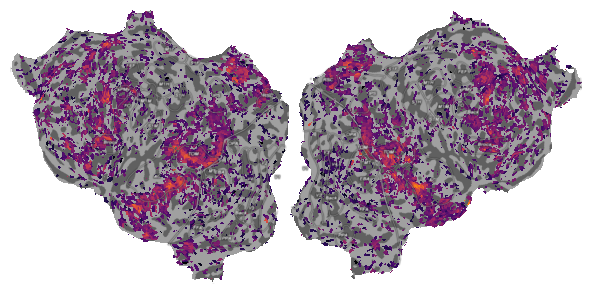

plotting COL zh
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


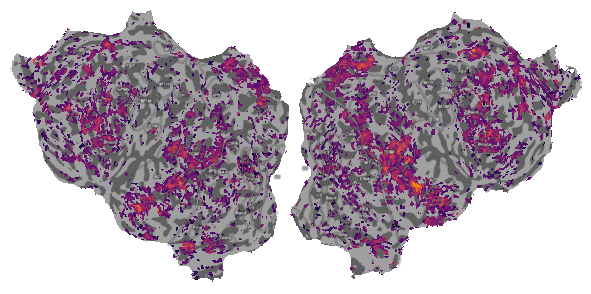

plotting GFW en
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


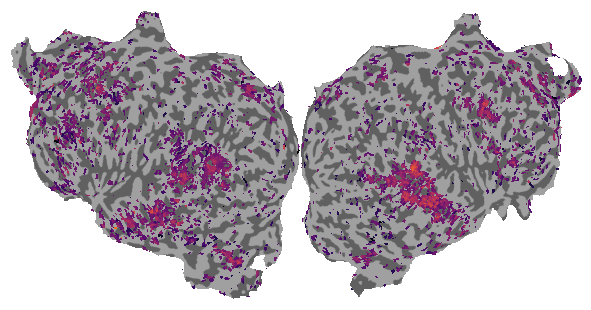

plotting GFW zh
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


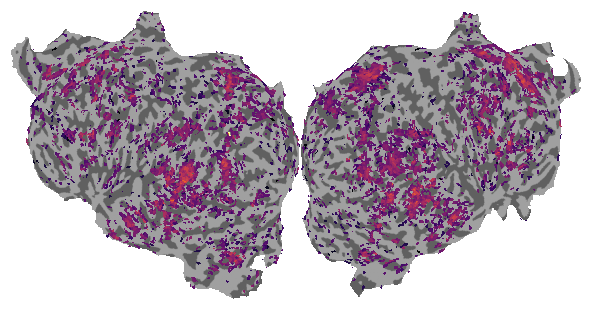

plotting TYE en
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


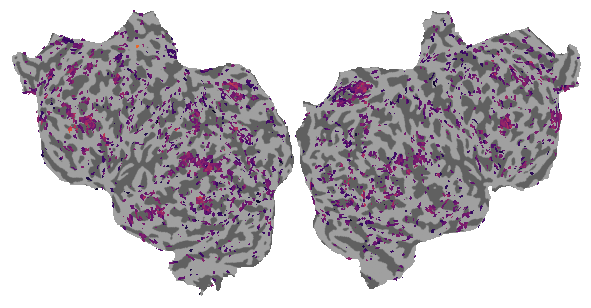

plotting TYE zh
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


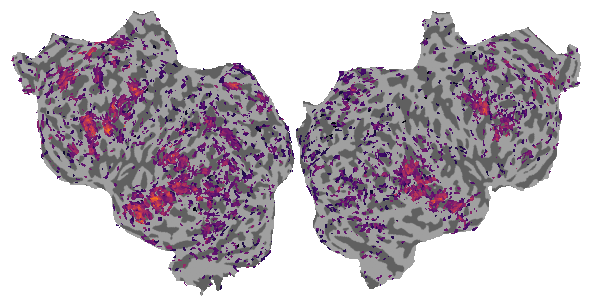

In [9]:
for id in subject_ids:
    surface_dict = get_surface_dict(id)
    for lang in ['en', 'zh']:
        print(f"plotting {id} {lang}")
        score = stats[id][lang]
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        plot_simple_flatmap(
            score,
            surface_dict,
            vmin=vmin,
            vmax=vmax,
            cmap='inferno',
            ax = ax,
        )
        
        save_path=f".temp/image/{analysis_name}/{id}/{lang}_flatmap.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()

plotting COL en
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)
plotting COL zh
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)
plotting GFW en
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)
plotting GFW zh
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)
plotting TYE en
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)
plotting TYE zh
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


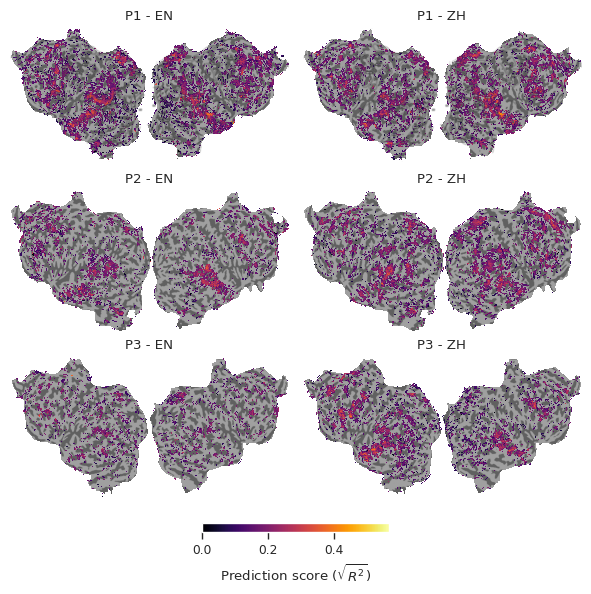

In [19]:
fig = plt.figure(figsize=(6,6))

gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 0.1], width_ratios=[1, 1])

languages = ['en', 'zh']

for i,id in enumerate(subject_ids):
    surface_dict = get_surface_dict(id)
    for j, lang in enumerate(languages):
        print(f"plotting {id} {lang}")
        score = stats[id][lang]
        
        ax = fig.add_subplot(gs[i, j])
        
        plot_simple_flatmap(
            score,
            surface_dict,
            vmin=vmin,
            vmax=vmax,
            cmap='inferno',
            ax = ax,
        )
        # write language on top middle
        ax.set_title(f"{id_to_label[id]} - {lang.upper()}")

        # write subject id if first column
    
        
# now colorbar
ax = fig.add_subplot(gs[-1, :])

cmap = plt.get_cmap('inferno')
norm = plt.Normalize(vmin, vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, orientation='horizontal', label=r'Prediction score ($\sqrt{R^2}$)', location='bottom', fraction=0.6)

ax.remove()
# save images
save_path=f".temp/image/{analysis_name}/pred_score_flatmap.png"

if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()


# Score Distributions

In [16]:
subject_ids

['COL', 'GFW', 'TYE']

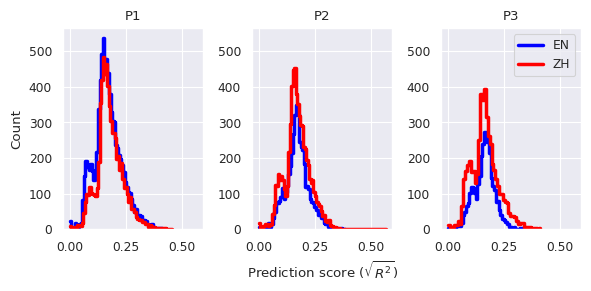

In [17]:
# plot score distributions
fig = plt.figure(figsize=(6,3))

gs = fig.add_gridspec(1, 3)

for i, id in enumerate(subject_ids):
        if i == 0:
                ax = fig.add_subplot(gs[0, i])
        else:
                ax = fig.add_subplot(gs[0, i], sharey=ax, sharex=ax)  # Add sharex and sharey parameters

        lang = 'en'
        color = 'blue'
        score = valid_scores[id][lang]

        sns.histplot(score, ax=ax, color=color, fill=False, element='step', label='EN')
        
        lang = 'zh'
        color = 'red'
        score = valid_scores[id][lang]

        sns.histplot(score, ax=ax, color=color, fill=False, element='step', label='ZH')

        ax.set_title(f"{id_to_label[id]}")
        
        if i == 0:
                ax.set_ylabel("Count")
        else:
                ax.set_ylabel("")
        
        if i == 2:
                ax.legend()
        if i == 1:
                ax.set_xlabel(r"Prediction score ($\sqrt{R^2}$)")

plt.tight_layout()

save_path=f".temp/image/{analysis_name}/pred_score_dist.png"

if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

plt.savefig(save_path, dpi=300)

plt.show()

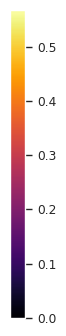

In [13]:
# plot cbar vertical 
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('inferno')
norm = plt.Normalize(vmin, vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax)

ax.remove()


save_fn = f".temp/image/{analysis_name}/cbar_vertical.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)

plt.show()


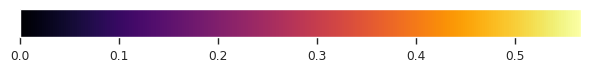

In [14]:
# plot cbar horizontal
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('inferno')
norm = plt.Normalize(vmin, vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, orientation='horizontal')

ax.remove()

plt.tight_layout()

save_fn = f".temp/image/{analysis_name}/cbar_horizontal.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)